# Retro — Figure 3


In [1]:
import os
import fsspec
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

## Load the data


In [2]:
with fsspec.open(
    "https://carbonplan.blob.core.windows.net/carbonplan-retro/results/reclassification-crediting-error.json", "r"
) as f:
    data = json.load(f)
del data["ACR360"]
del data["CAR1102"]

In [3]:
with fsspec.open(
    "https://carbonplan.blob.core.windows.net/carbonplan-retro/projects/retro-db-light-v1.0.json",
    "r",
) as f:
    db = json.load(f)
db = list(filter(lambda x: ~(x["id"] == "ACR360") & ~(x["id"] == "CAR1102"), db))

In [4]:
def get(id):
    return [x for x in db if x["id"] == id][0]

In [5]:
df = pd.DataFrame()
df["id"] = [key for key in data.keys()]
df["percent_low"] = [
    np.percentile(data[key]["delta_arbocs"], 25) / get(key)["arbocs"]["issuance"]
    for key in data.keys()
]
df["percent_med"] = [
    np.percentile(data[key]["delta_arbocs"], 50) / get(key)["arbocs"]["issuance"]
    for key in data.keys()
]
df["percent_high"] = [
    np.percentile(data[key]["delta_arbocs"], 75) / get(key)["arbocs"]["issuance"]
    for key in data.keys()
]
df["absolute_low"] = [np.percentile(data[key]["delta_arbocs"], 5) for key in data.keys()]
df["absolute_med"] = [np.percentile(data[key]["delta_arbocs"], 50) for key in data.keys()]
df["absolute_high"] = [np.percentile(data[key]["delta_arbocs"], 95) for key in data.keys()]
df["project_size"] = [get(key)["arbocs"]["issuance"] for key in data.keys()]
df["cp_slag"] = [get(key)["carbon"]["common_practice"]["value"] for key in data.keys()]
df["alternate_slag"] = [np.percentile(data[key]["alt_slag"], 50) for key in data.keys()]
df = df.sort_values("percent_med", ascending=False)

## Make the plot


In [6]:
def format_si(num, precision=0, suffixes=["", "K", "M", "G", "T", "P"], show_suffix=False):
    m = sum([abs(num / 1000.0 ** x) >= 1 for x in range(1, len(suffixes))])
    if show_suffix:
        return f"{num/1000.0**m:.{precision}f}{suffixes[m]}"
    else:
        return f"{num/1000.0**m:.{precision}f}"


def format_pt(num, precision=0, show_suffix=False):
    if show_suffix:
        return f"{num * 100:.{precision}f}%"
    else:
        return f"{num * 100:.{precision}f}"


@ticker.FuncFormatter
def formatter_si(x, pos):
    return format_si(x)


@ticker.FuncFormatter
def formatter_pt(x, pos):
    return format_pt(x)

In [7]:
total = []
for i in range(1000):
    total.append(np.nansum([data[key]["delta_arbocs"][i] for key in data.keys()]))
    total_arbocs = np.percentile(total, [5, 50, 95])
    total_percentage = np.percentile(total, [5, 50, 95]) / np.sum(
        [[x for x in db if x["id"] == key][0]["arbocs"]["issuance"] for key in data.keys()]
    )

In [8]:
for i in range(3):
    print(format_si(total_arbocs[i], precision=2, show_suffix=True))

18.82M
28.18M
37.65M


In [9]:
for i in range(3):
    print(format_pt(total_percentage[i], precision=2, show_suffix=True))

18.44%
27.61%
36.89%


In [10]:
for i in range(3):
    print(format_si(total_arbocs[i] * 13.67, precision=2, show_suffix=True))

257.25M
385.18M
514.72M


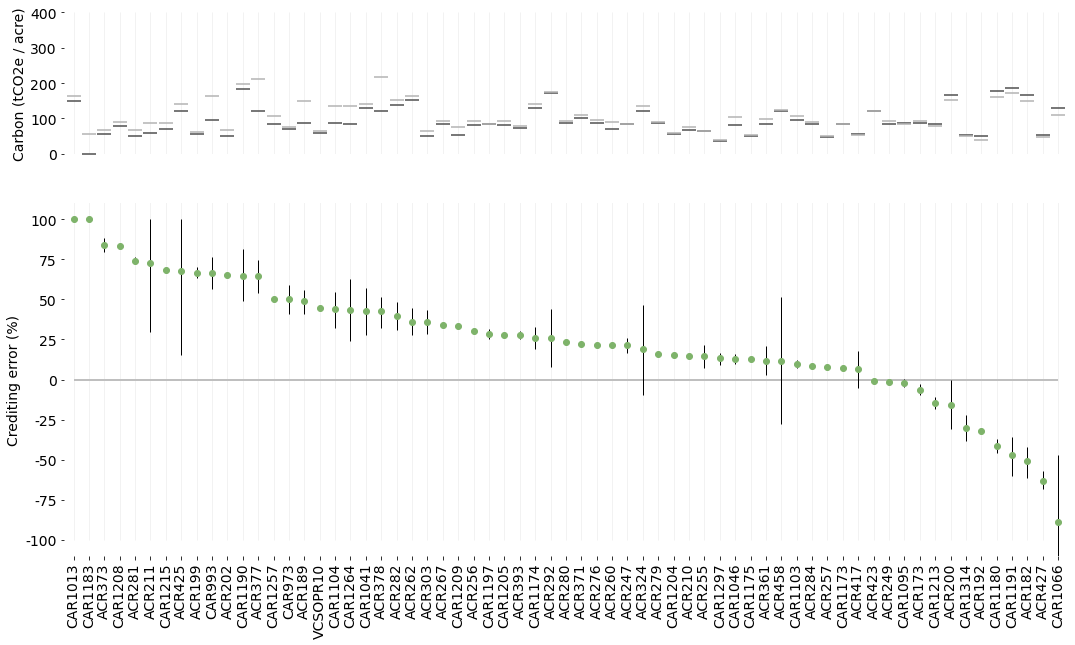

In [11]:
plt.rcParams.update({"font.size": 14, "svg.fonttype": "none"})

fig, axs = plt.subplots(2, 1, figsize=[18, 10], gridspec_kw={"height_ratios": [1, 2.5]})

axs[0].spines["left"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].vlines(df["id"], 0, 400, color=(0.95, 0.95, 0.95), linewidth=1)
axs[0].scatter(
    df["id"],
    df["cp_slag"],
    marker="_",
    s=200,
    color=".3",
    lw=1.5,
    label="Common practice",
    zorder=10,
)
axs[0].scatter(
    df["id"],
    df["alternate_slag"],
    marker="_",
    s=200,
    color=".7",
    lw=1.5,
    label="Common practice",
    zorder=10,
)

axs[0].set_xticks([])
axs[0].set_ylim([0, 400])
axs[0].set_ylabel("Carbon (tCO2e / acre)")
axs[0].margins(0.01)

axs[1].spines["left"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].spines["bottom"].set_visible(False)
axs[1].vlines(df["id"], -1, 1.5, color=(0.95, 0.95, 0.95), linewidth=1)
axs[1].hlines([0], [0], [len(df) - 1], color=(0.75, 0.75, 0.75), linewidth=2)
axs[1].plot(df["id"], df["percent_med"], ".", color="#7EB36A", markersize=12)
axs[1].vlines(df["id"], df["percent_low"], df["percent_high"], color="black", linewidth=1)
axs[1].set_xticks([])
axs[1].set_ylim([-1.1, 1.1])
axs[1].set_ylabel("Crediting error (%)")
axs[1].yaxis.set_major_formatter(formatter_pt)
axs[1].margins(0.01)
axs[1].set_xticks(df["id"])
axs[1].set_xticklabels(df["id"], rotation="vertical")
axs[1].tick_params(axis="x", which="major", pad=3)

fname = "Figure-3.svg"
if "BLOB_ACCOUNT_KEY" in os.environ:
    with fsspec.open(
        f"az://carbonplan-retro/figures/raw/{fname}",
        "w",
        account_name="carbonplan",
        account_key=os.environ["BLOB_ACCOUNT_KEY"],
    ) as f:
        fig.savefig(f, format="svg")
else:
    plt.savefig(fname)